## Data Wrangling

In [9]:
import os
import cv2
import random
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Image

from sklearn.model_selection import train_test_split

In [2]:
# Create a list to hold data
data_list = []

# Define classes
data_path = '/Users/renatoboemer/code/edge/raw_data'
for folder in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder)
    
    # Check if the item is a directory
    if os.path.isdir(folder_path):
        for image in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image)
            label = folder
            data_list.append({'image_path': image_path, 'label': label})

# Convert list to DataFrame
data = pd.DataFrame(data_list)


In [3]:
data.head()

,image_path,label
0,/Users/renatoboemer/code/edge/raw_data/cloudy/...,cloudy
1,/Users/renatoboemer/code/edge/raw_data/cloudy/...,cloudy
2,/Users/renatoboemer/code/edge/raw_data/cloudy/...,cloudy
3,/Users/renatoboemer/code/edge/raw_data/cloudy/...,cloudy
4,/Users/renatoboemer/code/edge/raw_data/cloudy/...,cloudy


In [4]:
print('Labels: ', data.label.unique())
classes = data.label.unique()
data['label'].value_counts()

Labels:  ['cloudy' 'water' 'green_area' 'desert']


label
cloudy        1500
water         1500
green_area    1500
desert        1131
Name: count, dtype: int64

## Data Augumentation

The `desert` class is slightly imbalanced. To balance the dataset by augmenting the `desert` images, we will have to create an additional 
1500−1131=**369 images**. Let's apply a couple of data augmentation techniques to address this issue:
- rotation
- translation

Given these augmentations, each original `desert` image would generate 7 additional images (3 from rotations and 4 from translations).

To achieve 369 new images, we will need to process ⌈369/7⌉=53 original `desert` images.

In [10]:
def rotate_image(image, angle):
    rows, cols, _ = image.shape
    M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1) 
    return cv2.warpAffine(image, M, (cols, rows))

def translate_image(image, x_shift, y_shift):
    rows, cols, _ = image.shape
    M = np.float32([[1, 0, x_shift], [0, 1, y_shift]])
    return cv2.warpAffine(image, M, (cols, rows))

In [11]:
# Paths to desert images
desert_path = '/Users/renatoboemer/code/edge/raw_data/desert'
desert_image_paths = []

for image in os.listdir(desert_path):
    image_path = os.path.join(desert_path, image)
    desert_image_paths.append(image_path)
    

In [13]:
# Shuffle the paths to randomize which images we are augmenting
random.shuffle(desert_image_paths)

augmented_images = []

for i, path in enumerate(desert_image_paths[:53]):
    image = cv2.imread(path)

    # Extracting the filename without extension
    filename = os.path.basename(path)
    base_filename, file_extension = os.path.splitext(filename)
    
    # Rotations
    cv2.imwrite(os.path.join(desert_path, f"{base_filename}_rotated_-15{file_extension}"), rotate_image(image, -15))
    cv2.imwrite(os.path.join(desert_path, f"{base_filename}_rotated_15{file_extension}"), rotate_image(image, 15))
    cv2.imwrite(os.path.join(desert_path, f"{base_filename}_rotated_30{file_extension}"), rotate_image(image, 30))
    
    # Translations
    cv2.imwrite(os.path.join(desert_path, f"{base_filename}_translated_right{file_extension}"), translate_image(image, 25, 0))
    cv2.imwrite(os.path.join(desert_path, f"{base_filename}_translated_left{file_extension}"), translate_image(image, -25, 0))
    cv2.imwrite(os.path.join(desert_path, f"{base_filename}_translated_down{file_extension}"), translate_image(image, 0, 25))
    cv2.imwrite(os.path.join(desert_path, f"{base_filename}_translated_up{file_extension}"), translate_image(image, 0, -25))


In [22]:
# Create a list to hold data
new_data_list = []

# Define classes
data_path = '/Users/renatoboemer/code/edge/raw_data'
for folder in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder)
    
    # Check if the item is a directory
    if os.path.isdir(folder_path):
        for image in os.listdir(folder_path):
            if image.endswith(('.jpg', '.png')):
                image_path = os.path.join(folder_path, image)
                label = folder
                new_data_list.append({'image_path': image_path, 'label': label})

In [23]:
# Convert list to DataFrame
df = pd.DataFrame(new_data_list)

# Print total count and count per label
print(f"Total images: {len(df)}")
print(df['label'].value_counts())

Total images: 6002
label
desert        1502
cloudy        1500
water         1500
green_area    1500
Name: count, dtype: int64


## Check an image

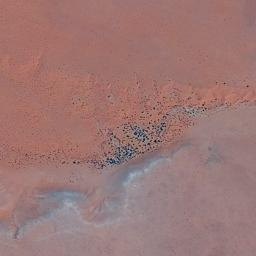

In [24]:
# Specify the path to your image
image_path = '/Users/renatoboemer/code/edge/raw_data/desert/desert(57).jpg'

# Read the image
img = cv2.imread(image_path)

# Check if the image was loaded successfully
if img is None:
    print("Error: Couldn't load the image.")
else:
    # Display the image in the notebook
    display(Image(data=cv2.imencode('.jpg', img)[1].tobytes()))


In [25]:
# Printing the size (height, width, channels)
print("image dimensions:", img.shape)

# Print image type
print(img.dtype)

image dimensions: (256, 256, 3)
uint8


Images are in 8-bit. Ideally, we would like to train our model using 32-bit to improve accuracy but it will not be possible.

## Resize & Normalize images

In [26]:
def resize_images_in_directory(main_directory, target_size=(224, 224)):
    """
    Resize all images in the given directory and its sub-directories to the target size.

    :param main_directory: Path to the main directory.
    :param target_size: Tuple indicating target size (width, height).
    """
    
    resized = False  # Flag to indicate if any images were resized
    
    for root, dirs, files in os.walk(main_directory):
        for file in files:
            # Check if the file is an image
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(root, file)
                
                # Read and resize the image
                img = cv2.imread(image_path)
                if img is not None:  # Check if image was loaded successfully
                    resized_img = cv2.resize(img, target_size)
                    
                    # Save the resized image back to the same path, effectively replacing it
                    cv2.imwrite(image_path, resized_img)
                    resized = True  # Set the flag to indicate that at least one image was resized

    if resized:
        print("Resizing complete.")
    else:
        print("No images were resized.")


In [27]:
main_directory = "/Users/renatoboemer/code/edge/raw_data"
resize_images_in_directory(main_directory, target_size=(224, 224))

Resizing complete.


In [28]:
def normalize_images(main_directory):
    """
    Normalize pixel values of all images in the given directory and its sub-directories to the [0, 1] range.
    """
    
    normalized = False  # Initialize a flag to check if any images were normalized

    for root, dirs, files in os.walk(main_directory):
        for file in files:
            # Check if the file is an image (e.g., has a .jpg or .png extension).
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(root, file)

                # Read the image
                img = cv2.imread(image_path)
                if img is not None:  # Check if image was loaded successfully
                    # Normalize pixel values to the [0, 1] range
                    img_normalized = img.astype(np.float32) / 255.0

                    # Save the normalized image
                    cv2.imwrite(image_path, (img_normalized * 255))

                    normalized = True  # Set the flag to indicate that at least one image was normalized

    if normalized:
        print("Normalization complete.")
    else:
        print("Images not normalized.")


In [29]:
main_directory = "/Users/renatoboemer/code/edge/raw_data"
normalize_images(main_directory)

Normalization complete.


## Train, Test, Split

In [30]:
train_df, val_test_df = train_test_split(data, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=42)

In [31]:
print("Number of training samples: ", train_df.shape[0])
print("Number of validation samples: ", val_df.shape[0])
print("Number of testing samples: ", test_df.shape[0])

Number of training samples:  4504
Number of validation samples:  563
Number of testing samples:  564


## Model

Satellites, especially those with onboard processing for tasks like image classification, have limitations when it comes to power, memory, and computational resources. This contrasts with the extensive resources available on the ground in data centers. Therefore, the convolutional neural networks (CNNs) employed on satellites tend to prioritise efficiency and resource conservation.

Given those constraints, I have decided to use [Keras MobileNet](https://keras.io/api/applications/mobilenet/). 

MobileNet is a class of efficient deep learning neural network architectures designed primarily for mobile and edge devices, rather than server-based applications. The goal of MobileNet is to provide a lightweight model that offers good performance while being computationally efficient, thereby allowing for real-time inference on devices with limited computational resources, such as a satellite 🛰️.

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Define input shape
input_shape = (224, 224, 3)

# Create MobileNetV3-Small model
base_model = MobileNetV3Small(input_shape=input_shape, include_top=False, weights='imagenet')

# Add custom classification layers on top
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(4, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


In [ ]:
model.summary()

In [ ]:
# Optional: Train the model with your dataset
# Replace 'train_data' and 'validation_data' with your own datasets
# model.fit(train_data, validation_data=validation_data, epochs=num_epochs)
